# Ensemble/Voting Classification in Python with Scikit-Learn
ref：https://www.kaggle.com/c/titanic/submit

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
import warnings 
warnings.filterwarnings('ignore')

In [181]:
training_data =pd.read_csv('data/train.csv')
testing_data = pd.read_csv('data/test.csv')
def get_nulls(training, testing):
    print("Training Data:")
    print(pd.isnull(training).sum())
    print("Testing Data:")
    print(pd.isnull(testing).sum())

get_nulls(training_data, testing_data)

Training Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [182]:
# Drop the cabin column, as there are too many missing values
# Drop the ticket numbers too, as there are too many categories
# Drop names as they won't really help predict survivors
training_data.drop(labels=['Cabin','Ticket','Name'],axis=1,inplace=True)
testing_data.drop(labels=['Cabin','Ticket','Name'],axis=1,inplace=True)
training_data.head()
testing_data.head()
# Taking the mean/average value would be impacted by the skew
# so we should use the median value to impute missing values
training_data["Age"].fillna(training_data["Age"].median(),inplace=True)
training_data["Embarked"].fillna('S',inplace=True)
testing_data["Age"].fillna(training_data["Age"].median(),inplace=True)
testing_data["Fare"].fillna(training_data["Fare"].median(),inplace=True)
print("補值後的結果:")
get_nulls(training_data, testing_data)

補值後的結果:
Training Data:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Testing Data:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


In [183]:
# Fit the encoder on the data (Feature: Sex)
encoder_1 = LabelEncoder()
encoder_1.fit(training_data["Sex"])

# Transform and replace training data
training_sex_encoded = encoder_1.transform(training_data["Sex"])
training_data["Sex"] = training_sex_encoded
test_sex_encoded = encoder_1.transform(testing_data["Sex"])
testing_data["Sex"] = test_sex_encoded

# Fit the encoder on the data (Feature: Embarked)
encoder_2 = LabelEncoder()
encoder_2.fit(training_data["Embarked"])

# Any value we want to reshape needs be turned into array first
ages_train = np.array(training_data["Age"]).reshape(-1, 1)
fares_train=np.array(training_data["Fare"]).reshape(-1, 1)
ages_test=np.array(testing_data["Age"]).reshape(-1, 1)
fares_test=np.array(testing_data["Fare"]).reshape(-1, 1)

# Scaler takes arrays
scaler = StandardScaler()

training_data["Age"] = scaler.fit_transform(ages_train)
training_data["Fare"]=scaler.fit_transform(fares_train)
testing_data["Age"]=scaler.fit_transform(ages_test)
testing_data["Fare"]=scaler.fit_transform(fares_test)

In [184]:
# Now to select our training/testing data
x_features = training_data.drop(labels=['PassengerId', 'Survived','Embarked'], axis=1)
y_labels = training_data['Survived']

print(x_features.head(5))
print(y_labels.head(5))

# Make the train/test data from validation

x_train, x_val, y_train, y_val = train_test_split(x_features, y_labels, test_size=0.1,random_state=12)


   Pclass  Sex       Age  SibSp  Parch      Fare
0       3    1 -0.565736      1      0 -0.502445
1       1    0  0.663861      1      0  0.786845
2       3    0 -0.258337      0      0 -0.488854
3       1    0  0.433312      1      0  0.420730
4       3    1  0.433312      0      0 -0.486337
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


## Simple Averaging Approach

In [185]:
LogReg_clf = LogisticRegression()
DTree_clf = DecisionTreeClassifier()
SVC_clf = SVC()

LogReg_clf.fit(x_train, y_train)
DTree_clf.fit(x_train, y_train)
SVC_clf.fit(x_train, y_train)

LogReg_pred = LogReg_clf.predict(x_val)
DTree_pred = DTree_clf.predict(x_val)
SVC_pred = SVC_clf.predict(x_val)

averaged_preds = (LogReg_pred + DTree_pred + SVC_pred)//3
acc = accuracy_score(y_val, averaged_preds)
print("accuracy score:")
print(acc)

accuracy score:
0.8


## Bagging Classification Example

In [186]:
logreg_bagging_model=BaggingClassifier(base_estimator=LogReg_clf,n_estimators=50,random_state=12)
dtree_bagging_model=BaggingClassifier(base_estimator=DTree_clf,n_estimators=50,random_state=12)
random_forest=RandomForestClassifier(n_estimators=100,random_state=12)
extra_trees=ExtraTreesClassifier(n_estimators=100,random_state=12)

def bagging_ensemble(model):
    k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
    results = cross_val_score(model, x_train, y_train, cv=k_folds)
    print(results.mean())
    
bagging_ensemble(logreg_bagging_model)
bagging_ensemble(dtree_bagging_model)
bagging_ensemble(random_forest)
bagging_ensemble(extra_trees)

0.7939634146341463
0.8163719512195122
0.8113719512195121
0.7951829268292683


## Boosting Classification Example

Results for 20 estimators:
0.8002134146341463
Results for 40 estimators:
0.8127134146341464
Results for 60 estimators:
0.8089024390243902
Results for 80 estimators:
0.8151524390243903
Results for 100 estimators:
0.8126524390243903


Text(0.5, 1.0, 'change of results for estimators:')

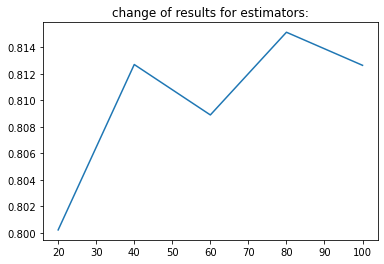

In [187]:
k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
num_estimators = [20, 40, 60, 80, 100]
a=[]
b=np.array([20,40,60,80,100])
for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators=i,random_state=12)
    results = cross_val_score(ada_boost,x_train,y_train,cv=k_folds)
    print("Results for {} estimators:".format(i))
    print(results.mean())
    a.append(results.mean())
plt.plot(b,a)
plt.title('change of results for estimators:')

## voting\Stacking Classification Example

In [192]:
SVC_clf = SVC(probability=False)
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='hard')
voting_clf.fit(x_train, y_train)
preds = voting_clf.predict(x_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)
print("Hard Voting Classifier")
print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

Hard Voting Classifier
Accuracy is: 0.8333333333333334
Log Loss is: 5.756524923396351
F1 Score is: 0.782608695652174


In [188]:
SVC_clf = SVC(probability=True)
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='soft')
voting_clf.fit(x_train, y_train)
preds = voting_clf.predict(x_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)
print("Soft Voting Classifier")
print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

Soft Voting Classifier
Accuracy is: 0.8666666666666667
Log Loss is: 4.605196839235765
F1 Score is: 0.8125


In [189]:
training_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,-0.565736,1,0,-0.502445,S
1,2,1,1,0,0.663861,1,0,0.786845,C
2,3,1,3,0,-0.258337,0,0,-0.488854,S
3,4,1,1,0,0.433312,1,0,0.420730,S
4,5,0,3,1,0.433312,0,0,-0.486337,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,-0.181487,0,0,-0.386671,S
887,888,1,1,0,-0.796286,0,0,-0.044381,S
888,889,0,3,0,-0.104637,1,2,-0.176263,S
889,890,1,1,1,-0.258337,0,0,-0.044381,C


In [193]:
testing_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,0.371062,0,0,-0.497413,Q
1,893,3,0,1.358985,1,0,-0.512278,S
2,894,2,1,2.544493,0,0,-0.464100,Q
3,895,3,1,-0.221692,0,0,-0.482475,S
4,896,3,0,-0.616861,1,1,-0.417492,S
...,...,...,...,...,...,...,...,...
413,1305,3,1,-0.142658,0,0,-0.493455,S
414,1306,1,0,0.726714,0,0,1.314435,C
415,1307,3,1,0.687197,0,0,-0.507796,S
416,1308,3,1,-0.142658,0,0,-0.493455,S


In [194]:
test=testing_data.drop(labels=['PassengerId','Embarked'],axis=1)
test.shape

(418, 6)

In [195]:
submission_df=pd.DataFrame(columns=['PassengerId','Survived'])
submission_df['PassengerId']=testing_data['PassengerId']
preds=voting_clf.predict(test)
submission_df['Survived']=preds
submission_df.to_csv('submissions.csv',header=True,index=False)

In [196]:
submission_df2=pd.DataFrame(columns=['PassengerId','Survived'])
submission_df2['PassengerId']=testing_data['PassengerId']
preds2=DTree_clf.predict(test)
submission_df2['Survived']=preds2
submission_df2.to_csv('submissions2.csv',header=True,index=False)

In [197]:
submission_df3=pd.DataFrame(columns=['PassengerId','Survived'])
submission_df3['PassengerId']=testing_data['PassengerId']
preds3= LogReg_clf.predict(test)
submission_df3['Survived']=preds3
submission_df3.to_csv('submissions3.csv',header=True,index=False)